## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Data cleaning
*By Kaylee Mo*

To start we had to merge our 3 datasets

1. We first decided to left merge the Tutition and Barron's Selectivity datasets with the Top Colleges dataset. We decided to do left merge because Top Colleges had the most colleges we were interested in. 

2. We then ran into a problem where we couldn't left merge with the typical pandas left merge because the college names were not exact. For example, UC Berkeley was also University of California, Berkeley in another dataset. We thus had to import the package FuzzyMatcher. Fuzzymatcher takes the 2 college names and based on their similarity, creates a score. Fuzzymatcher then uses a threshold, and if that score is above the threshold, the 2 college names are merged together. 

3. Lastly, there were many variables in the final dataset. We did initial cleaning where we dropped the variables where we knew we were not interested in. For example, we did not need the description of the colleges, the phone number and website of the college, and more. 

The code below implements the above cleaning.

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy.ma as ma
import numpy as np
import fuzzymatcher
import statsmodels.formula.api as sm

top_colleges_list = pd.read_csv('top_colleges_2022.csv')
barrons = pd.read_csv('Barrons College List.csv')
tuition = pd.read_csv('tuition_cost.csv')
tuition = tuition.drop(['state', 'state_code', 'type', 'degree_length',
       'room_and_board', 'in_state_tuition', 'in_state_total', 'out_of_state_total'], axis = 1)
barrons.columns = barrons.columns.str.rstrip()
barrons['College Name'] = barrons['College Name'].astype(str)
barrons['College Name'] = barrons['College Name'].apply(lambda x: x.strip())
data = fuzzymatcher.fuzzy_left_join(top_colleges_list, barrons, ['organizationName'], ['College Name'])
data = data.drop(['best_match_score', '__id_left', '__id_right','description', 'longitude', 'latitude', 'website', 'phoneNumber', 'carnegieClassification', 'studentPopulation', 'College Name', 'City and State'], axis = 1)
data2 = fuzzymatcher.fuzzy_left_join(data, tuition, ['organizationName'], ['name'])
data = data2.drop(['best_match_score', '__id_left', '__id_right','yearFounded', 'stateCode', 'name'], axis = 1)

### Data quality check
*By Kaylee Mo*

The code below visualizes the distribution of all the variables in the dataset, and their association with the response.

In [13]:
#Distribution of variables
data[['medianBaseSalary', 'rank', 'studentFacultyRatio', 'undergradPop', 'out_of_state_tuition', 'Selectivity', 'totalGrantAid']].describe()

,medianBaseSalary,rank,studentFacultyRatio,undergradPop,out_of_state_tuition,Selectivity,totalGrantAid
count,491.000000,498.000000,498.000000,498.000000,498.000000,498.000000,4.950000e+02
mean,116382.077393,249.485944,14.120482,12075.550201,36441.395582,2.255020,2.491186e+07
std,17161.769465,143.899350,5.203074,12628.161452,13053.807507,0.803178,1.936898e+07
min,77300.000000,1.000000,3.000000,421.000000,4105.000000,1.000000,2.307030e+05
25%,104300.000000,125.250000,10.000000,2613.750000,25159.000000,2.000000,1.219794e+07
50%,112800.000000,249.500000,13.500000,6844.500000,36480.500000,2.000000,1.904380e+07
75%,125000.000000,373.750000,17.000000,18655.250000,48431.750000,3.000000,3.218453e+07
max,173700.000000,498.000000,49.000000,84202.000000,59985.000000,3.000000,1.575583e+08


In [14]:
# Distribution of our 1 categorical variable Selectivity (values of 1,2,3 for most selective to least selective)
data.Selectivity.value_counts()

3.0    240
2.0    145
1.0    113
Name: Selectivity, dtype: int64

In [15]:
#Association of the response with the predictors

data[['medianBaseSalary', 'rank', 'studentFacultyRatio', 'undergradPop', 'out_of_state_tuition', 'Selectivity', 'totalGrantAid']].corr()

,medianBaseSalary,rank,studentFacultyRatio,undergradPop,out_of_state_tuition,Selectivity,totalGrantAid
medianBaseSalary,1.000000,-0.645747,-0.442872,-0.158305,0.584428,-0.494202,0.201261
rank,-0.645747,1.000000,0.102519,-0.289547,-0.391347,0.419108,-0.460018
studentFacultyRatio,-0.442872,0.102519,1.000000,0.605834,-0.659826,0.310886,0.132181
undergradPop,-0.158305,-0.289547,0.605834,1.000000,-0.415883,0.109013,0.597566
out_of_state_tuition,0.584428,-0.391347,-0.659826,-0.415883,1.000000,-0.435413,0.174126
Selectivity,-0.494202,0.419108,0.310886,0.109013,-0.435413,1.000000,-0.114388
totalGrantAid,0.201261,-0.460018,0.132181,0.597566,0.174126,-0.114388,1.000000


### Data Preparation
*By Kaylee Mo*

Lastly, to prep the data for model development, we checked the null values of the variables we were interested in. As you can see below, there were only 7 numbers missing max for a variable, which we found to be a relatively small number compared to the total number of observations. We dropped all null values and then started model development.

The code below implements the checking and dropping of null values.

In [16]:
# checking amount of null values
data[['medianBaseSalary', 'rank', 'studentFacultyRatio', 'undergradPop', 'out_of_state_tuition', 'Selectivity', 'totalGrantAid']].isnull().sum(axis=0)

medianBaseSalary        7
rank                    0
studentFacultyRatio     0
undergradPop            0
out_of_state_tuition    0
Selectivity             0
totalGrantAid           3
dtype: int64

In [17]:
data = data.dropna(axis=0)

## Exploratory data analysis
*by Ashley Witarsa*

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

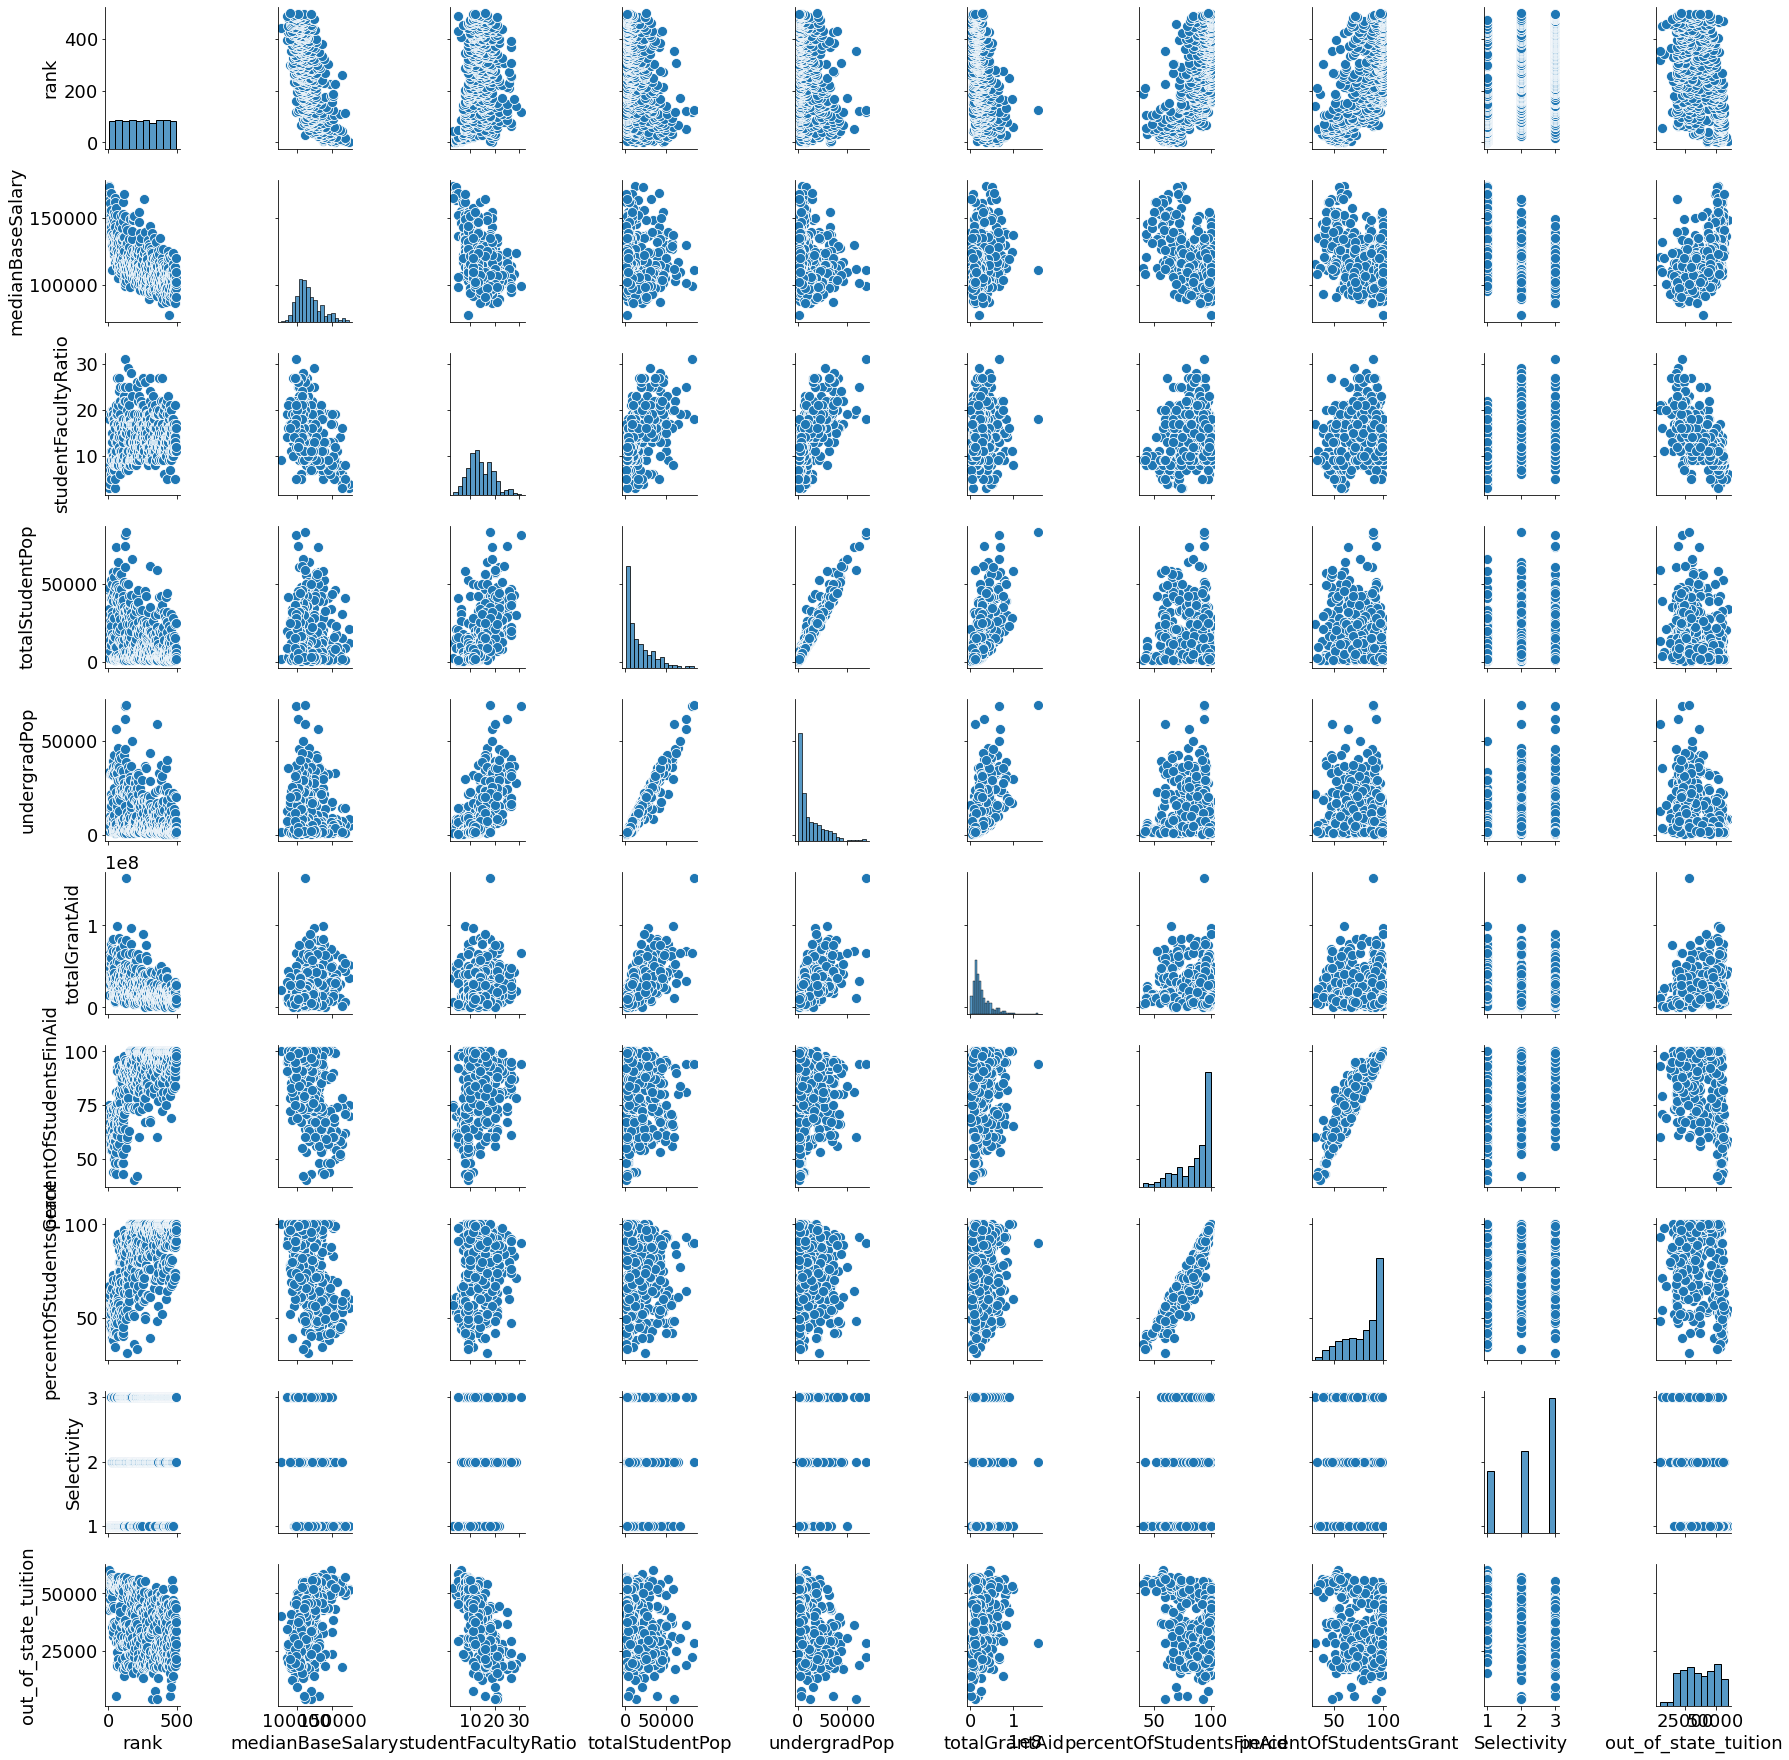

In [18]:
# First, we wanted to visualize the relationship between the different variables.
sns.pairplot(data)

In [25]:
# Looking at correlation between variables 
data.corr()

# out_of_state_total & studentFacultyRatio seem to be highly correlated

,rank,medianBaseSalary,studentFacultyRatio,totalStudentPop,undergradPop,totalGrantAid,percentOfStudentsFinAid,percentOfStudentsGrant,Selectivity,out_of_state_tuition
rank,1.000000,-0.645332,0.104158,-0.368774,-0.301877,-0.467038,0.651516,0.605133,0.427657,-0.386750
medianBaseSalary,-0.645332,1.000000,-0.443229,-0.074030,-0.156016,0.202065,-0.492029,-0.428602,-0.486363,0.578837
studentFacultyRatio,0.104158,-0.443229,1.000000,0.577120,0.664584,0.147832,0.124652,0.042722,0.339866,-0.697677
totalStudentPop,-0.368774,-0.074030,0.577120,1.000000,0.973690,0.659760,-0.204889,-0.261773,0.078069,-0.321548
undergradPop,-0.301877,-0.156016,0.664584,0.973690,1.000000,0.588302,-0.161342,-0.227700,0.130711,-0.409883
totalGrantAid,-0.467038,0.202065,0.147832,0.659760,0.588302,1.000000,-0.109698,-0.081362,-0.103527,0.194223
percentOfStudentsFinAid,0.651516,-0.492029,0.124652,-0.204889,-0.161342,-0.109698,1.000000,0.958937,0.512090,-0.280560
percentOfStudentsGrant,0.605133,-0.428602,0.042722,-0.261773,-0.227700,-0.081362,0.958937,1.000000,0.444521,-0.148754
Selectivity,0.427657,-0.486363,0.339866,0.078069,0.130711,-0.103527,0.512090,0.444521,1.000000,-0.442609
out_of_state_tuition,-0.386750,0.578837,-0.697677,-0.321548,-0.409883,0.194223,-0.280560,-0.148754,-0.442609,1.000000


In [19]:
# Next, we wanted used VIF to see if any of the variables have a high linear correlation
X = data[['Selectivity', 'studentFacultyRatio', 'undergradPop', 'rank', 'out_of_state_tuition', 'totalGrantAid']]
X.columns[1:]
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

vif_data # all of the variables (except const) have VIF values of less than 5, indicating a small amount of collinearity

,feature,VIF
0,const,87.007709
1,Selectivity,1.415238
2,studentFacultyRatio,2.987181
3,undergradPop,3.991629
4,rank,1.899697
5,out_of_state_tuition,3.074411
6,totalGrantAid,2.366419


## Developing the model
*By Ashley Witarsa*

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

In [20]:
# Model with all the predictors
model = smf.ols('medianBaseSalary~Selectivity+studentFacultyRatio+undergradPop+rank+out_of_state_tuition+totalGrantAid', data = data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       medianBaseSalary   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     116.7
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           4.39e-90
Time:                        14:10:39   Log-Likelihood:                -5154.3
No. Observations:                 481   AIC:                         1.032e+04
Df Residuals:                     474   BIC:                         1.035e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.416e+05   4671.757     30.312      0.000    1.32e+05    1.51e+05
Selectivity          -2312.3152    745.803     -3.100      0.002   -3777.803    -846.827
studentFacultyRatio   -452.3809    174.649     -2.590      0.010    -795.563    -109.199
undergradPop            -0.2694      0.082     -3.289      0.001      -0.430      -0.108
rank                   -69.3506      4.808    -14.425      0.000     -78.798     -59.903
out_of_state_tuition     0.1743      0.068      2.578      0.010       0.041       0.307
totalGrantAid          2.36e-05   4.01e-05      0.589      0.556   -5.51e-05       0.000
==============================================================================
Omnibus:                       27.453   Durbin-Watson:                   1.744
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.685
Skew:                           0.514   Prob(JB):                     4.85e-08
Kurtosis:                       3.791   Cond. No.                     2.93e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.93e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
# Best subset selection without interaction

X = data[['Selectivity', 'studentFacultyRatio', 'undergradPop', 'rank', 'out_of_state_tuition', 'totalGrantAid']]

def processSubset(predictor_subset):
    model = smf.ols('medianBaseSalary~' + '+'.join(predictor_subset),data = data).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k):
        results.append(processSubset((list(combo))))

    models = pd.DataFrame(results)

    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [22]:
import itertools
import time

models_best = pd.DataFrame(columns=["Rsquared", "model"])

tic = time.time()
for i in range(1,1+X.shape[1]):
    models_best.loc[i] = getBest_model(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 6 models on 1 predictors in 0.07831025123596191 seconds.
Processed 15 models on 2 predictors in 0.22266530990600586 seconds.
Processed 20 models on 3 predictors in 0.2582838535308838 seconds.
Processed 15 models on 4 predictors in 0.306110143661499 seconds.
Processed 6 models on 5 predictors in 0.0878591537475586 seconds.
Processed 1 models on 6 predictors in 0.022011995315551758 seconds.
Total elapsed time: 1.0185542106628418 seconds.


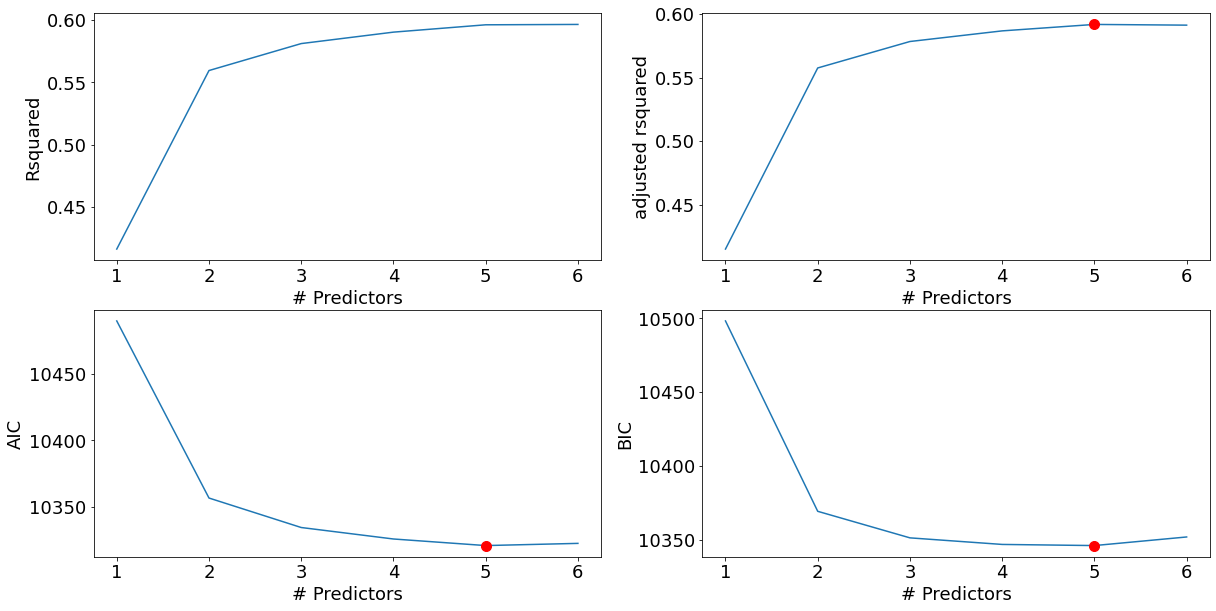

In [23]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [24]:
best_subset_model = models_best.loc[5,'model']
best_model = models_best.loc[5,'model']
best_model.summary()
# dropping totalGrantAid did not seem to change R^2 at all. Insignificant variable
# Wanted to run best subset selection with interactions but it took way too long

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       medianBaseSalary   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     140.2
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           4.18e-91
Time:                        14:12:45   Log-Likelihood:                -5154.5
No. Observations:                 481   AIC:                         1.032e+04
Df Residuals:                     475   BIC:                         1.035e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.413e+05   4634.920     30.482      0.000    1.32e+05     1.5e+05
Selectivity          -2285.2357    743.873     -3.072      0.002   -3746.925    -823.546
studentFacultyRatio   -458.0076    174.268     -2.628      0.009    -800.439    -115.576
undergradPop            -0.2395      0.064     -3.729      0.000      -0.366      -0.113
rank                   -69.5126      4.797    -14.492      0.000     -78.938     -60.087
out_of_state_tuition     0.1911      0.061      3.123      0.002       0.071       0.311
==============================================================================
Omnibus:                       27.018   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               33.304
Skew:                           0.505   Prob(JB):                     5.86e-08
Kurtosis:                       3.801   Cond. No.                     3.72e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.72e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

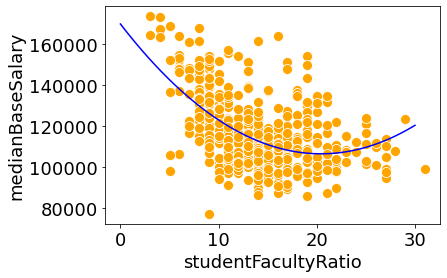

In [34]:
# Variable Transformations
sns.scatterplot(x = 'studentFacultyRatio', y = 'medianBaseSalary', data = data, color = 'orange')
fit = np.polyfit(data.studentFacultyRatio, data.medianBaseSalary, 2)

quad_func = np.poly1d(fit)
x_fit = np.linspace(0, 30, 100)
y_fit = quad_func(x_fit)
plt.plot(x_fit, y_fit, 'b')
plt.show()
# Relationship between medianBaseSalary and studentFacultyRatio looks quadratic

Text(0, 0.5, 'Median Base Salary')

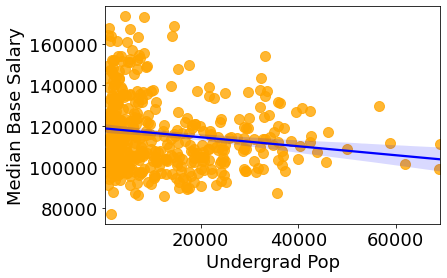

In [35]:
ax = sns.regplot(x = data.undergradPop, y =data.medianBaseSalary,color = 'orange', line_kws = {'color':'blue'})
plt.xlabel('Undergrad Pop')
plt.ylabel('Median Base Salary')
# Seems to have a lot of variance in undergrad population

Text(0, 0.5, 'Median Base Salary')

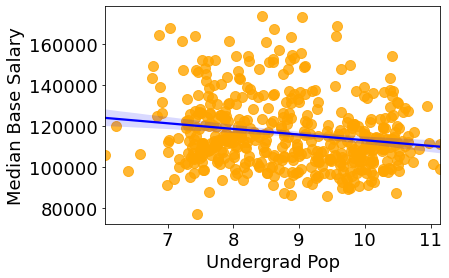

In [37]:
# Log transformation on undergrad population to reduce variance
log_undergradPop = np.log(data['undergradPop'])
ax = sns.regplot(x = log_undergradPop, y =data.medianBaseSalary,color = 'orange', line_kws = {'color':'blue'})
plt.xlabel('Undergrad Pop')
plt.ylabel('Median Base Salary')

### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

## Conclusions and Recommendations to stakeholder(s)

You may or may not have code to put in this section. Delete this section if it is irrelevant.